In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from helper import get_all_data, get_mult_data, get_sub_data, get_labels

labels = get_labels()

def svm_show_results_skf(X_avg, y_avg, task_name):
    # 2. Define Pipeline
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(f_classif, k=100)),
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', C=1.0, random_state=42))
    ])
    
    # 3. Stratified K Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_all = []
    y_test_all = []
    
    for train_idx, test_idx in skf.split(X_avg, y_avg):
        pipeline.fit(X_avg[train_idx], y_avg[train_idx])
        predictions = pipeline.predict(X_avg[test_idx])
        y_pred_all.extend(predictions)
        y_test_all.extend(y_avg[test_idx])
    
    y_pred_all = np.array(y_pred_all)
    y_test_all = np.array(y_test_all)
    acc = accuracy_score(y_test_all, y_pred_all)
    
    print(f"\n{'='*120}")
    print(f"{task_name} (Averaged) Accuracy: {acc * 100:.2f}%")
    print(classification_report(y_test_all, y_pred_all, target_names=['TD', 'MLD']))

    # 4. Plotting Confusion Matrix
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_avg, y_pred_all)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Pred TD', 'Pred MLD'], yticklabels=['Actual TD', 'Actual MLD'])
    plt.title(f"{task_name} Confusion Matrix")
    plt.show()

    # 5. Feature Importance (Weights)
    # Fit on the WHOLE averaged dataset to get the most stable features
    pipeline.fit(X_avg, y_avg)
    
    support = pipeline.named_steps['feature_selection'].get_support()
    feature_indices = np.where(support)[0]
    weights = pipeline.named_steps['svm'].coef_[0]

    # Map to ROI pairs (Schaefer 400 uses upper triangle indices)
    roi_indices = np.triu_indices(400, k=1)
    roi_pairs = list(zip(roi_indices[0], roi_indices[1]))

    print(f"\nTop 10 Strongest Connections for {task_name}:")
    print(f"{'Brain Connection':<55} | {'Weight':<10}")
    print("-" * 70)

    # Sort by absolute weight value
    sorted_idx = np.argsort(np.abs(weights))[::-1]

    for i in sorted_idx[:10]:
        feat_idx = feature_indices[i]
        roi_a, roi_b = roi_pairs[feat_idx]
        
        name_a = labels[roi_a] 
        name_b = labels[roi_b]
        
        # Clean labels and print
        connection_str = f"{name_a[:25]} <-> {name_b[:25]}"
        print(f"{connection_str:<55} | {weights[i]:.4f}")
    
    return y_test_all, y_pred_all

[fetch_atlas_schaefer_2018] Dataset found in /Users/jchong058/nilearn_data/schaefer_2018



All (Averaged) Accuracy: 53.33%
              precision    recall  f1-score   support

          TD       0.53      0.60      0.56        15
         MLD       0.54      0.47      0.50        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30



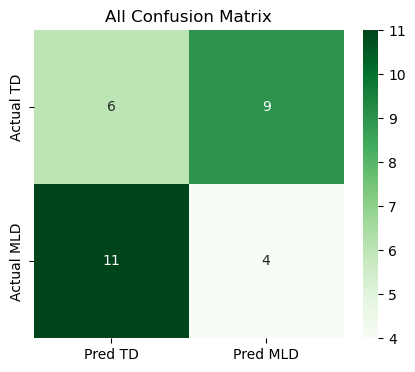


Top 10 Strongest Connections for All:
Brain Connection                                        | Weight    
----------------------------------------------------------------------
7Networks_RH_SomMot_17 <-> 7Networks_RH_DorsAttn_FEF    | 0.1341
7Networks_RH_SomMot_38 <-> 7Networks_RH_Cont_PFCl_8     | -0.1234
7Networks_LH_Cont_PFCl_5 <-> 7Networks_RH_Limbic_TempP  | 0.1083
7Networks_LH_Vis_16 <-> 7Networks_LH_DorsAttn_Pos       | 0.1000
7Networks_LH_Default_Par_ <-> 7Networks_RH_Vis_2        | -0.0993
7Networks_RH_SomMot_37 <-> 7Networks_RH_Limbic_OFC_5    | -0.0943
7Networks_LH_Vis_27 <-> 7Networks_RH_DorsAttn_FEF       | 0.0936
7Networks_LH_Limbic_TempP <-> 7Networks_RH_DorsAttn_Pos | 0.0905
7Networks_LH_SomMot_16 <-> 7Networks_LH_Cont_PFCl_5     | 0.0859
7Networks_LH_Limbic_TempP <-> 7Networks_RH_DorsAttn_Pos | 0.0840


In [2]:
X_avg, y_avg = get_all_data()
y_true_s, y_pred_s = svm_show_results_skf(X_avg, y_avg, "All")


Multiplication (Averaged) Accuracy: 66.67%
              precision    recall  f1-score   support

          TD       0.67      0.67      0.67        15
         MLD       0.67      0.67      0.67        15

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30



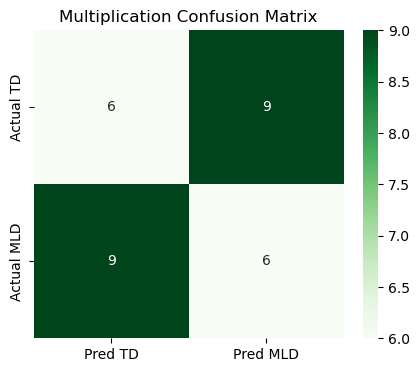


Top 10 Strongest Connections for Multiplication:
Brain Connection                                        | Weight    
----------------------------------------------------------------------
7Networks_RH_SomMot_38 <-> 7Networks_RH_Cont_PFCl_8     | -0.1673
7Networks_LH_DorsAttn_Pos <-> 7Networks_LH_Default_Par_ | 0.1106
7Networks_LH_DorsAttn_Pos <-> 7Networks_RH_Vis_14       | 0.1070
7Networks_RH_Vis_17 <-> 7Networks_RH_Default_PFCd       | 0.1029
7Networks_LH_DorsAttn_Pos <-> 7Networks_RH_Vis_11       | 0.1002
7Networks_RH_SomMot_25 <-> 7Networks_RH_SalVentAttn_    | 0.0777
7Networks_LH_SomMot_23 <-> 7Networks_RH_SalVentAttn_    | -0.0769
7Networks_LH_Limbic_TempP <-> 7Networks_RH_SomMot_35    | 0.0750
7Networks_LH_Limbic_TempP <-> 7Networks_RH_Default_Par_ | 0.0742
7Networks_LH_DorsAttn_Pos <-> 7Networks_RH_SomMot_18    | 0.0726


In [3]:
# --- For Multiplication (task_id = 1) ---
X_avg_m, y_avg_m = get_mult_data()
y_true_m, y_pred_m = svm_show_results_skf(X_avg_m, y_avg_m, "Multiplication")


Subtraction (Averaged) Accuracy: 36.67%
              precision    recall  f1-score   support

          TD       0.39      0.47      0.42        15
         MLD       0.33      0.27      0.30        15

    accuracy                           0.37        30
   macro avg       0.36      0.37      0.36        30
weighted avg       0.36      0.37      0.36        30



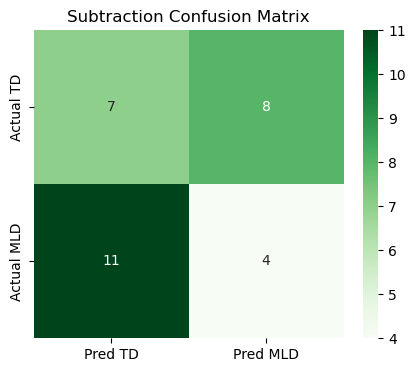


Top 10 Strongest Connections for Subtraction:
Brain Connection                                        | Weight    
----------------------------------------------------------------------
7Networks_LH_SomMot_29 <-> 7Networks_LH_Default_Par_    | -0.2384
7Networks_LH_Vis_16 <-> 7Networks_LH_DorsAttn_Pos       | 0.2050
7Networks_LH_SomMot_5 <-> 7Networks_RH_Cont_PFCl_5      | -0.1873
7Networks_LH_Vis_25 <-> 7Networks_RH_Cont_Par_2         | 0.1705
7Networks_LH_Default_Par_ <-> 7Networks_RH_Vis_2        | -0.1510
7Networks_LH_Default_Temp <-> 7Networks_RH_Default_PFCd | 0.1211
7Networks_LH_SomMot_32 <-> 7Networks_RH_Vis_19          | -0.1187
7Networks_LH_SalVentAttn_ <-> 7Networks_RH_Default_Par_ | -0.1167
7Networks_RH_SomMot_17 <-> 7Networks_RH_DorsAttn_FEF    | 0.1161
7Networks_LH_DorsAttn_FEF <-> 7Networks_RH_SalVentAttn_ | 0.1159


In [4]:
# --- For Subtraction (task_id = 0) ---
X_avg_s, y_avg_s = get_sub_data()
y_true_s, y_pred_s = svm_show_results_skf(X_avg_s, y_avg_s, "Subtraction")